In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import ast
import networkx as nx
from collections import Counter
os.chdir("/Users/adamouazzani/Documents/GitHub/ada-2024-project-theadacuates")

In [5]:
df_processed = pd.read_csv('./data/output/base_data/paths_processed.csv')

/var/folders/fn/4xlpvr555jx0gt6033j7x9lr0000gn/T/ipykernel_66737/323557432.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_processed = pd.read_csv('./data/output/base_data/paths_processed.csv')


In [6]:
df_processed['type_unfinished'].unique()

array([nan, 'timeout', 'restart'], dtype=object)

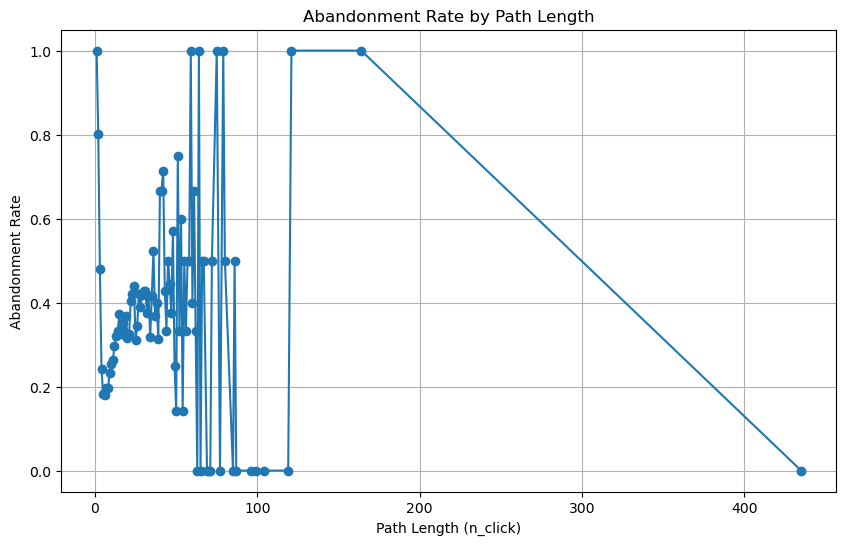

In [9]:
### Step 1: Analyze Path Length and Abandonment ###
# Calculate abandonment rate based on path length
# Group by path length and calculate the abandonment rate
abandonment_rate_by_length = df_processed.groupby('n_click')['finished'].apply(lambda x: 1 - x.mean())

# Plot abandonment rate vs. path length
plt.figure(figsize=(10, 6))
plt.plot(abandonment_rate_by_length.index, abandonment_rate_by_length.values, marker='o', linestyle='-')
plt.xlabel('Path Length (n_click)')
plt.ylabel('Abandonment Rate')
plt.title('Abandonment Rate by Path Length')
plt.grid(True)
plt.show()

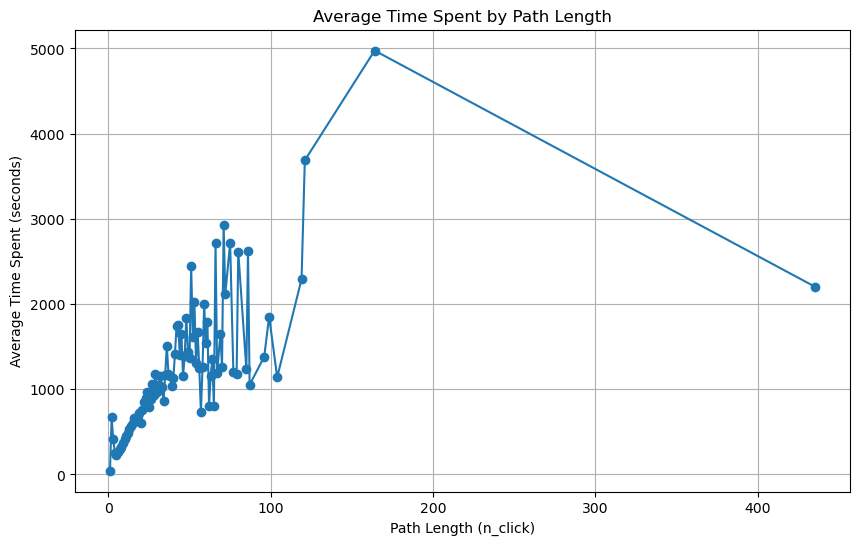

In [10]:
### Step 2: Length vs. Time Spent (Cognitive Load) ###
# Calculate average time spent per path length
time_by_length = df_processed.groupby('n_click')['duration'].mean()

# Plot average time spent vs. path length
plt.figure(figsize=(10, 6))
plt.plot(time_by_length.index, time_by_length.values, marker='o', linestyle='-')
plt.xlabel('Path Length (n_click)')
plt.ylabel('Average Time Spent (seconds)')
plt.title('Average Time Spent by Path Length')
plt.grid(True)
plt.show()

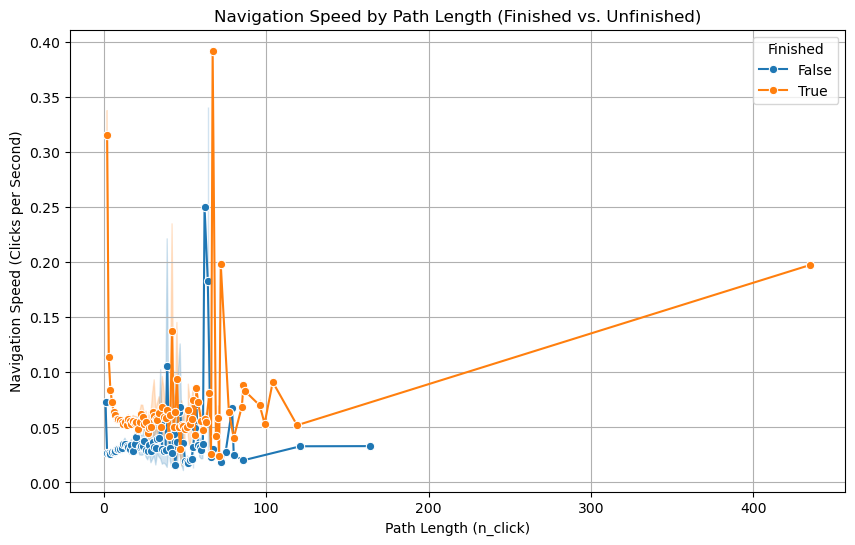

In [11]:
### Step 3: Analyze Navigation Speed ###
# Calculate speed (clicks per second) for each path
df_processed['speed'] = df_processed['n_click'] / df_processed['duration']

# Plot speed vs. path length for finished and unfinished paths
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_processed, x='n_click', y='speed', hue='finished', marker='o')
plt.xlabel('Path Length (n_click)')
plt.ylabel('Navigation Speed (Clicks per Second)')
plt.title('Navigation Speed by Path Length (Finished vs. Unfinished)')
plt.legend(title='Finished')
plt.grid(True)
plt.show()

Distribution of Unfinished Types:
 type_unfinished
NaN        51280
restart    15551
timeout     7309
Name: count, dtype: int64


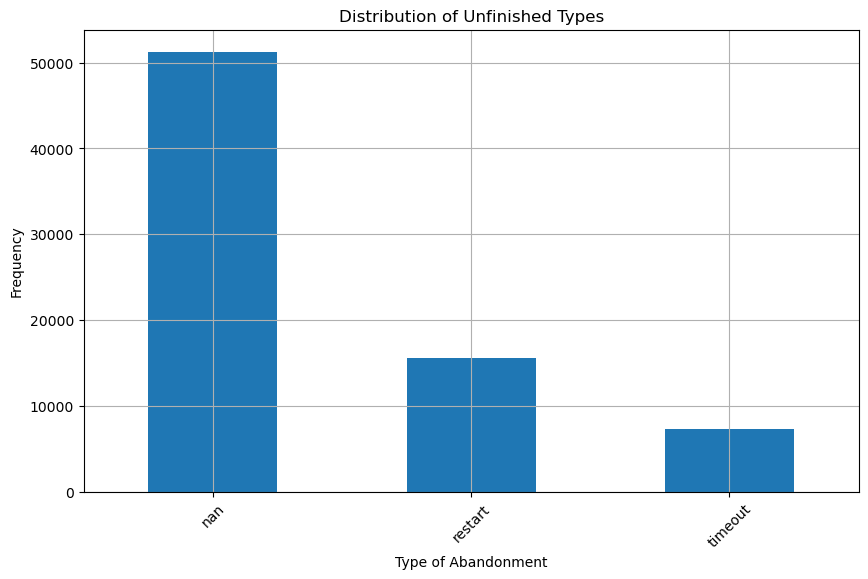

In [12]:
### Step 4: Analyze Specific Types of Abandonment (Type Unfinished) ###
# Distribution of abandonment types in `type_unfinished`
unfinished_types = df_processed['type_unfinished'].value_counts(dropna=False)
print("Distribution of Unfinished Types:\n", unfinished_types)

# Plot distribution of abandonment types
plt.figure(figsize=(10, 6))
unfinished_types.plot(kind='bar')
plt.xlabel('Type of Abandonment')
plt.ylabel('Frequency')
plt.title('Distribution of Unfinished Types')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/var/folders/fn/4xlpvr555jx0gt6033j7x9lr0000gn/T/ipykernel_66737/3916082278.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Finished')


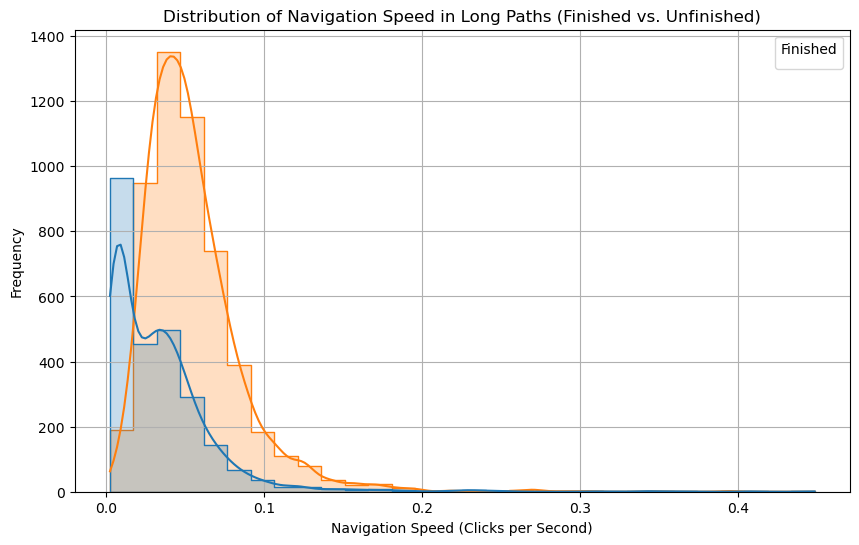

In [13]:
### Step 5: In-depth Analysis of Speed Patterns in Long Paths ###
# Define a threshold for "long paths" (e.g., paths with length > 10)
long_paths = df_processed[df_processed['n_click'] > 10]

# Plot distribution of speed for long paths (finished vs. unfinished)
plt.figure(figsize=(10, 6))
sns.histplot(long_paths, x='speed', hue='finished', kde=True, bins=30, element='step')
plt.xlabel('Navigation Speed (Clicks per Second)')
plt.ylabel('Frequency')
plt.title('Distribution of Navigation Speed in Long Paths (Finished vs. Unfinished)')
plt.legend(title='Finished')
plt.grid(True)
plt.show()


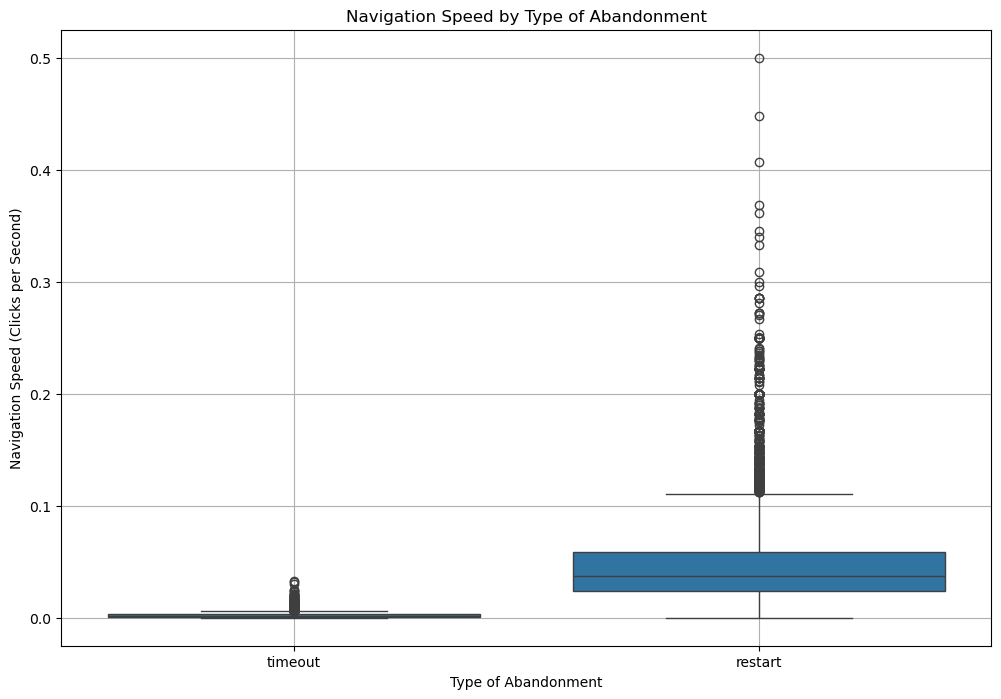

In [14]:
### Step 6: Analyze Speed Patterns by Specific Abandonment Types ###
# Filter unfinished paths and categorize by `type_unfinished`
unfinished_paths = df_processed[df_processed['finished'] == False]

# Plot speed for each type of abandonment
plt.figure(figsize=(12, 8))
sns.boxplot(data=unfinished_paths, x='type_unfinished', y='speed')
plt.xlabel('Type of Abandonment')
plt.ylabel('Navigation Speed (Clicks per Second)')
plt.title('Navigation Speed by Type of Abandonment')
plt.grid(True)
plt.show()